# kr-epi — Deterministic Tour (v0.1)

This notebook demostrates the deterministic side of `kr-epi` so far.

1. Basic fraction models: **SI, SIS, SIR, SIRS, SEIR**
2. Demographic **count** models: **SIR/SIS/SEIR** with births/deaths
3. **Vaccination at birth** (coverage `p`)
4. **Infection-induced mortality**
5. **Seasonal forcing** of β(t): sinusoidal and term-time

### Imports

In [30]:
from kr_epi.models.ode import SI, SIS, SIR, SIRS, SEIR
from kr_epi.models.ode_counts import (
    SIRDemographyCounts, SISDemographyCounts, SEIRDemographyCounts
)
from kr_epi.models.ode_counts_mortality import (
    SIRDemographyCountsMortality, delta_from_cfr
)
from kr_epi.forcing.sinusoid import BetaSinusoid
from kr_epi.forcing.term_time import TermTime

# for inline plots in Jupyter
# %matplotlib inline


### Helpers

In [31]:
def plot_ts(t, y, labels, title, ylabel="fraction"):
    fig, ax = plt.subplots(figsize=(7, 3.5))
    for i, name in enumerate(labels):
        ax.plot(t, y[i], label=name)
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig

def plot_counts(t, y, labels, title):
    return plot_ts(t, y, labels, title, ylabel="count")

def plot_beta(beta_fn, t_span=(0,365), n=600, title='β(t)'):
    t = np.linspace(*t_span, n)
    y = [beta_fn(tt) for tt in t]
    fig, ax = plt.subplots(figsize=(7,2.8))
    ax.plot(t, y)
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel('β(t)')
    ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig

### Basic Fraction Models

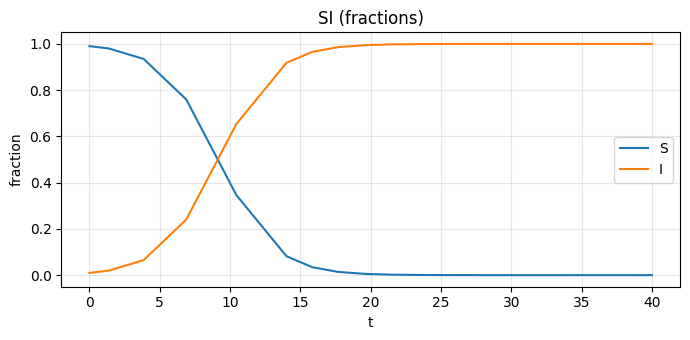

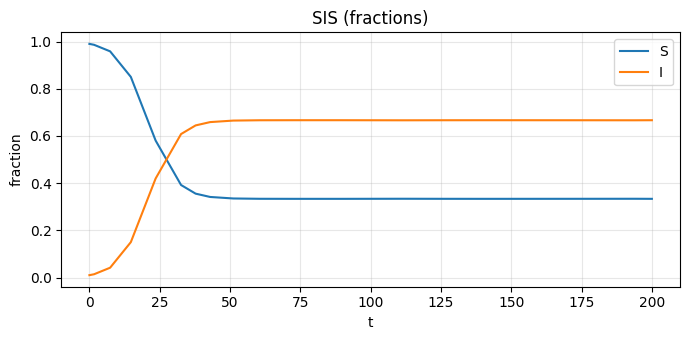

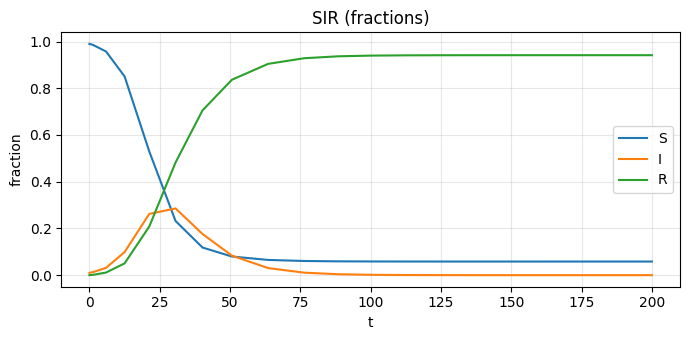

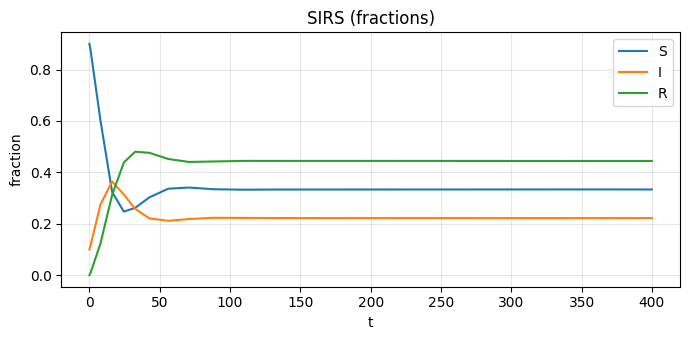

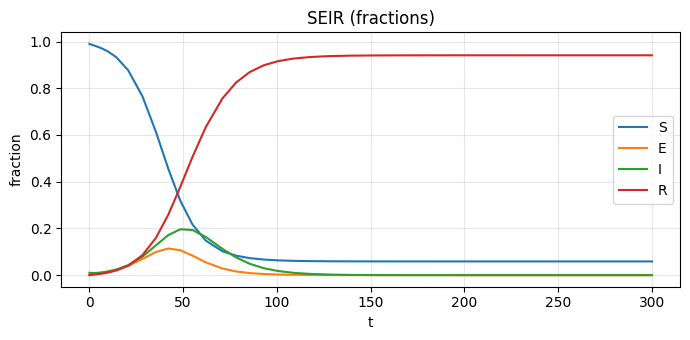

In [32]:
# SI
m = SI(beta=0.5)
t, y = m.integrate({'S':0.99, 'I':0.01}, (0, 40))
plot_ts(t, y, ['S','I'], 'SI (fractions)');

# SIS
m = SIS(beta=0.3, gamma=0.1)
t, y = m.integrate({'S':0.99, 'I':0.01}, (0, 200))
plot_ts(t, y, ['S','I'], 'SIS (fractions)');

# SIR (closed)
m = SIR(beta=0.3, gamma=0.1)
t, y = m.integrate({'S':0.99, 'I':0.01, 'R':0.0}, (0, 200))
plot_ts(t, y, ['S','I','R'], 'SIR (fractions)');

# SIRS (waning immunity)
m = SIRS(beta=0.3, gamma=0.1, omega=0.05)
t, y = m.integrate({'S':0.9, 'I':0.1, 'R':0.0}, (0, 400))
plot_ts(t, y, ['S','I','R'], 'SIRS (fractions)');

# SEIR (latent class)
m = SEIR(beta=0.3, sigma=0.2, gamma=0.1)
t, y = m.integrate({'S':0.99, 'E':0.0, 'I':0.01, 'R':0.0}, (0, 300))
plot_ts(t, y, ['S','E','I','R'], 'SEIR (fractions)');


### Demographic Counts Models

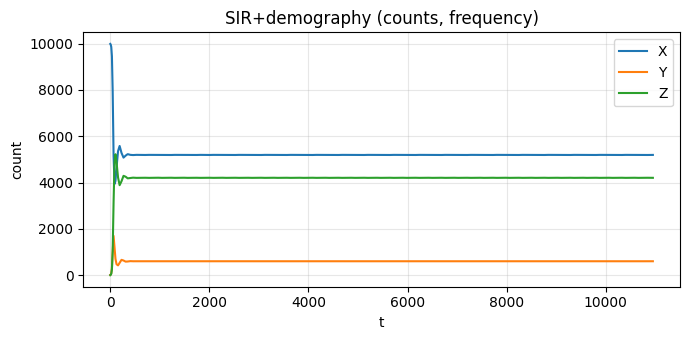

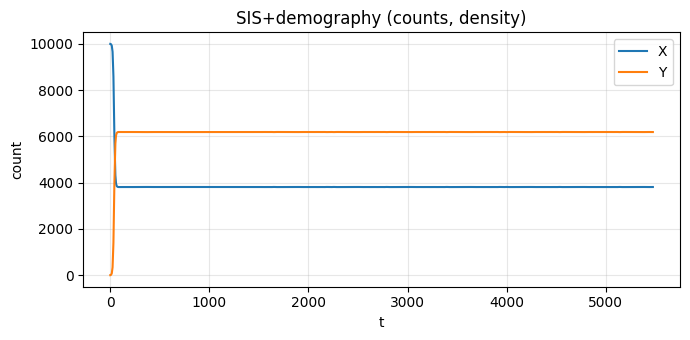

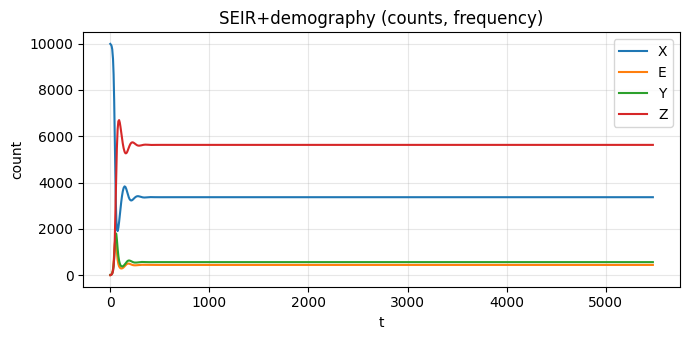

In [33]:
N0 = 10_000

# SIR + demography (frequency mixing)
sir = SIRDemographyCounts(beta=0.22, gamma=0.1, v=1/70, mu=1/70, mixing='frequency')
t, y = sir.integrate({'X':N0-10, 'Y':10.0, 'Z':0.0}, (0, 365*30))
plot_counts(t, y, ['X','Y','Z'], 'SIR+demography (counts, frequency)');

# SIS + demography (density mixing)
sis = SISDemographyCounts(beta=3e-5, gamma=0.1, v=1/70, mu=1/70, mixing='density')
t, y = sis.integrate({'X':N0-5, 'Y':5.0}, (0, 365*15))
plot_counts(t, y, ['X','Y'], 'SIS+demography (counts, density)');

# SEIR + demography (frequency mixing)
seir = SEIRDemographyCounts(beta=0.5, sigma=1/5, gamma=1/7, v=1/70, mu=1/70, mixing='frequency')
t, y = seir.integrate({'X':N0-10, 'E':0.0, 'Y':10.0, 'Z':0.0}, (0, 365*15))
plot_counts(t, y, ['X','E','Y','Z'], 'SEIR+demography (counts, frequency)');

### Vaccination at Birth

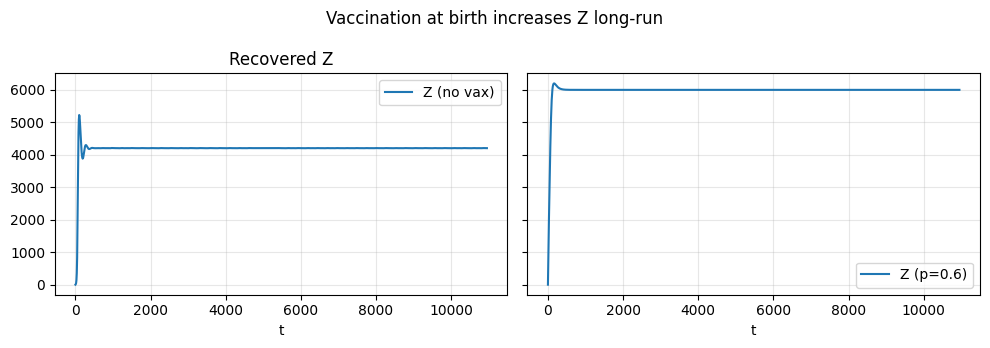

In [34]:
m_base = SIRDemographyCounts(beta=0.22, gamma=0.1, v=1/70, mu=1/70,
                             mixing='frequency', vacc_p=0.0)
m_vax  = SIRDemographyCounts(beta=0.22, gamma=0.1, v=1/70, mu=1/70,
                             mixing='frequency', vacc_p=0.6)

TSPAN = (0, 365*30)
t_eval = np.linspace(TSPAN[0], TSPAN[1], 1200)

t_base, y_base = m_base.integrate({'X':N0-10,'Y':10.0,'Z':0.0}, TSPAN, t_eval=t_eval)
t_vax,  y_vax  = m_vax.integrate( {'X':N0-10,'Y':10.0,'Z':0.0}, TSPAN, t_eval=t_eval)

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax[0].plot(t_base, y_base[2], label='Z (no vax)'); ax[0].set_title('Recovered Z'); ax[0].grid(alpha=0.3)
ax[1].plot(t_vax,  y_vax[2],  label='Z (p=0.6)');  ax[1].grid(alpha=0.3)
for a in ax: a.set_xlabel('t'); a.legend()
fig.suptitle('Vaccination at birth increases Z long-run'); fig.tight_layout();


### Infection Induced Mortality

delta (given): 0.08    delta_from_cfr(0.2): 0.028571428571428574


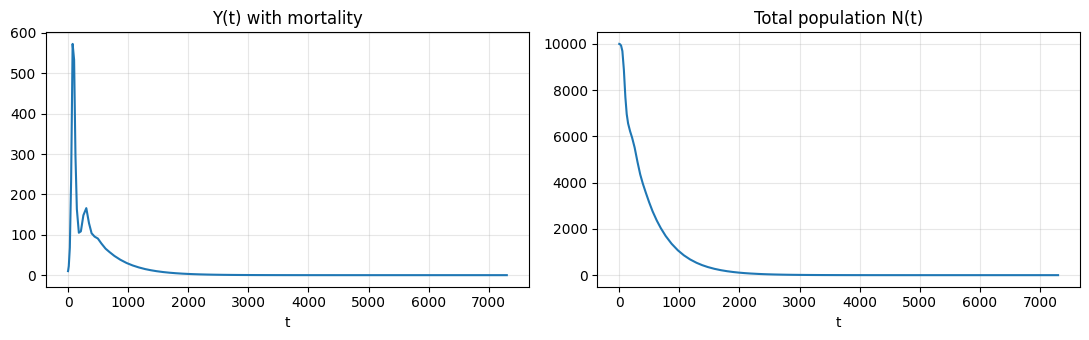

In [21]:
delta = 0.08
m_mort = SIRDemographyCountsMortality(
    beta=0.26, gamma=0.1, v=1/70, mu=1/70, delta=delta, mixing='frequency'
)
t, y = m_mort.integrate({'X':N0-10, 'Y':10.0, 'Z':0.0}, (0, 365*20))
N = y.sum(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(11, 3.5))
ax[0].plot(t, y[1]); ax[0].set_title('Y(t) with mortality'); ax[0].grid(alpha=0.3)
ax[1].plot(t, N);    ax[1].set_title('Total population N(t)'); ax[1].grid(alpha=0.3)
for a in ax:
    a.set_xlabel('t')
fig.tight_layout();

# sanity: convert CFR (rho) -> delta
rho = 0.2
delta2 = delta_from_cfr(rho, gamma=0.1, mu=1/70)
print("delta (given):", delta, "   delta_from_cfr(0.2):", delta2)

### Seasonal Forcing Example

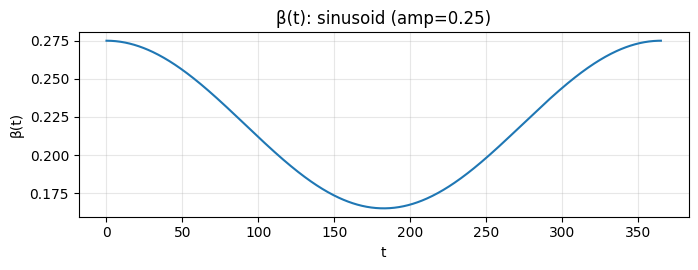

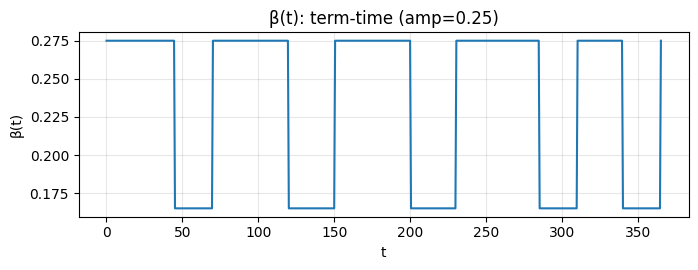

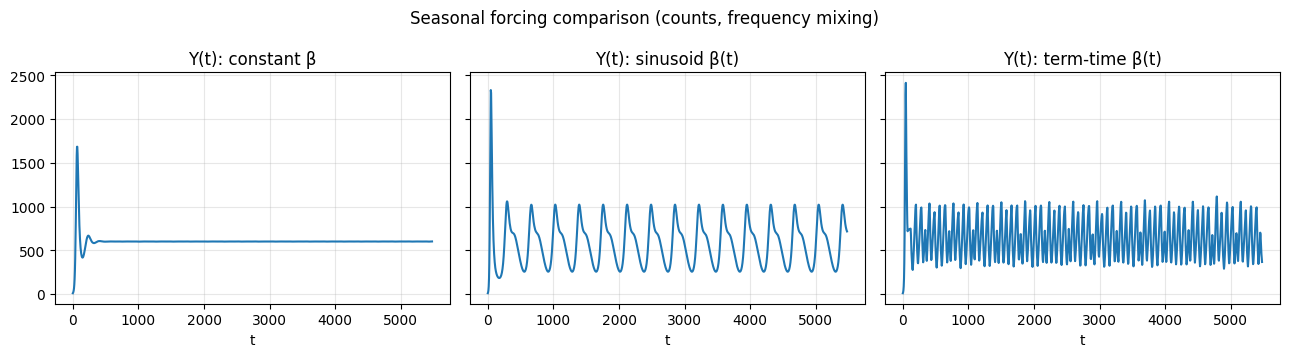

In [23]:
beta0, gamma, mu, v = 0.22, 0.1, 1/70, 1/70
y0c = {'X':N0-10, 'Y':10.0, 'Z':0.0}

m_const  = SIRDemographyCounts(beta=beta0, gamma=gamma, v=v, mu=mu, mixing='frequency')
m_forced = SIRDemographyCounts(beta=0.0,   gamma=gamma, v=v, mu=mu, mixing='frequency')

# forcing functions
sin = BetaSinusoid(beta0=beta0, amp=0.25, period=365)
tt  = TermTime(beta0=beta0, amp=0.25, period=365,
               term_windows=[(0,45),(70,120),(150,200),(230,285),(310,340)])

# visualize β(t)
plot_beta(sin, (0,365), title='β(t): sinusoid (amp=0.25)');
plot_beta(tt,  (0,365), title='β(t): term-time (amp=0.25)');

TSPAN = (0, 365*15)
t_eval = np.linspace(TSPAN[0], TSPAN[1], 1200)

_, y_const = m_const.integrate(y0c, TSPAN, t_eval=t_eval)
_, y_sin   = m_forced.integrate(y0c, TSPAN, t_eval=t_eval, beta_fn=sin)
_, y_tt    = m_forced.integrate(y0c, TSPAN, t_eval=t_eval, beta_fn=tt)

t = t_eval  # common x-axis

fig, ax = plt.subplots(1, 3, figsize=(13, 3.6), sharey=True)
ax[0].plot(t, y_const[1]); ax[0].set_title('Y(t): constant β'); ax[0].grid(alpha=0.3)
ax[1].plot(t, y_sin[1]);   ax[1].set_title('Y(t): sinusoid β(t)'); ax[1].grid(alpha=0.3)
ax[2].plot(t, y_tt[1]);    ax[2].set_title('Y(t): term-time β(t)'); ax[2].grid(alpha=0.3)
for a in ax: a.set_xlabel('t')
fig.suptitle('Seasonal forcing comparison (counts, frequency mixing)')
fig.tight_layout()
